# 实战Kaggle比赛：预测房价

实现几个函数来方便下载数据

In [44]:
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

def download(name, cache_dir=os.path.join('..', 'data')):  
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

def download_extract(name, folder=None):  
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

使用`pandas`读入并处理数据

In [45]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

DATA_HUB['kaggle_house_train'] = (  
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [46]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


前四个和最后两个特征，以及相应标签

In [47]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


在每个样本中，第一个特征是ID，
我们将其从数据集中删除

In [48]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

将所有缺失的值替换为相应特征的平均值。
通过将特征重新缩放到零均值和单位方差来标准化数据

In [49]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
all_features[numeric_features] = all_features[numeric_features].fillna(0)
print(all_features)

      MSSubClass MSZoning  LotFrontage   LotArea Street Alley LotShape  \
0       0.067320       RL    -0.184443 -0.217841   Pave   NaN      Reg   
1      -0.873466       RL     0.458096 -0.072032   Pave   NaN      Reg   
2       0.067320       RL    -0.055935  0.137173   Pave   NaN      IR1   
3       0.302516       RL    -0.398622 -0.078371   Pave   NaN      IR1   
4       0.067320       RL     0.629439  0.518814   Pave   NaN      IR1   
...          ...      ...          ...       ...    ...   ...      ...   
1454    2.419286       RM    -2.069222 -1.043758   Pave   NaN      Reg   
1455    2.419286       RM    -2.069222 -1.049083   Pave   NaN      Reg   
1456   -0.873466       RL     3.884968  1.246594   Pave   NaN      Reg   
1457    0.655311       RL    -0.312950  0.034599   Pave   NaN      Reg   
1458    0.067320       RL     0.201080 -0.068608   Pave   NaN      Reg   

     LandContour Utilities LotConfig  ... ScreenPorch  PoolArea PoolQC  Fence  \
0            Lvl    AllPub    

处理离散值。
我们用独热编码替换它们
#第一个特征（即为第一列）为[0,1,2,1],其中三类特征值[0,1,2],因此One-Hot Code可将[0,1,2]表示为:[100,010,001]
    gender  age  city
0   male   25  Beijing
1   male   30   Shanghai
2   female 28  Beijing
        age  gender_female  gender_male  gender_nan  city_Beijing  city_Shanghai    city_nan
0       25             0            1           0             1              0        0
1       30             0            1           0             0              1        0
2       28             1            0           0             1              0        0

In [50]:
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape
print(all_features)

      MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0       0.067320    -0.184443 -0.217841     0.646073    -0.507197   1.046078   
1      -0.873466     0.458096 -0.072032    -0.063174     2.187904   0.154737   
2       0.067320    -0.055935  0.137173     0.646073    -0.507197   0.980053   
3       0.302516    -0.398622 -0.078371     0.646073    -0.507197  -1.859033   
4       0.067320     0.629439  0.518814     1.355319    -0.507197   0.947040   
...          ...          ...       ...          ...          ...        ...   
1454    2.419286    -2.069222 -1.043758    -1.481667     1.289537  -0.043338   
1455    2.419286    -2.069222 -1.049083    -1.481667    -0.507197  -0.043338   
1456   -0.873466     3.884968  1.246594    -0.772420     1.289537  -0.373465   
1457    0.655311    -0.312950  0.034599    -0.772420    -0.507197   0.682939   
1458    0.067320     0.201080 -0.068608     0.646073    -0.507197   0.715952   

      YearRemodAdd  MasVnrArea  BsmtFin

从`pandas`格式中提取NumPy格式，并将其转换为张量表示

In [59]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

训练

In [52]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

我们更关心相对误差$\frac{y - \hat{y}}{y}$，
解决这个问题的一种方法是用价格预测的对数来衡量差异

In [60]:
def log_rmse(net, features, labels):
# torch.clamp(input, min, max, out=None) -> Tensor
# 其中，"input"参数是要进行限制的输入张量，"min"和"max"参数是表示下限和上限的标量值，这些值可以是数字或张量。
# 如果"min"或"max"的值为None，则表示不进行下限或上限的限制。
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

我们的训练函数将借助Adam优化器.相当于平滑的sgd，学习率的适用范围比较广

In [61]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # zero_grad()应该放在backward()计算梯度之前,用于清零上一个batch的梯度
            # 考虑了自定义优化器的情况,所以zero_grad()放在loss和backward()之间
            # 考虑PyTorch内置优化器,所以zero_grad()放在loss计算前面,方便清零梯度
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

K折交叉验证

In [62]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    # 样本数除以k
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        # slice(start, stop, step)
        # "start"参数是切片的起始位置（默认为0），
        # "stop"参数是切片的终止位置（不包含该位置的元素），
        # "step"参数是切片的步长（默认为1）。
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

返回训练和验证误差的平均值

In [56]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

模型选择

折1，训练log rmse0.170252, 验证log rmse0.156739
折2，训练log rmse0.162328, 验证log rmse0.189931
折3，训练log rmse0.163900, 验证log rmse0.168616
折4，训练log rmse0.168317, 验证log rmse0.154881
折5，训练log rmse0.163267, 验证log rmse0.183068
5-折验证: 平均训练log rmse: 0.165613, 平均验证log rmse: 0.170647


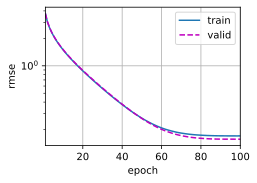

In [57]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

提交Kaggle预测

训练log rmse：0.162523


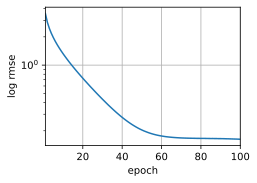

In [63]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # "detach()"方法将预测结果与计算图分离，得到一个新的张量（preds）。
    # 接着，使用"numpy()"方法将张量转换为NumPy数组，以便后续的处理。
    preds = net(test_features).detach().numpy()
    # 将预测结果转换为一维数组，并将其作为一个新的"Pandas Series"对象，
    # 赋值给测试数据集（test_data）中的"SalePrice"列。这样，测试数据集就包含了预测结果。
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    # "concat()"函数将测试数据集中的"Id"列和"SalePrice"列合并为一个新的数据集（submission），
    # 其中"axis=1"表示沿着列方向合并,新的数据集就包含了每个测试样本的ID和对应的预测结果。
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    # "Pandas"库中的"to_csv()"函数将新的数据集保存到CSV文件中（submission.csv），
    # 并将"index=False"参数设置为不保存索引。
    submission.to_csv('submission.csv', index=False)

train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)